# Evaluating geospatial ML models

## Estimating model error

After training a machine learning model, it is important to evaluate the model's performance and assess how suitable the model is for a particular task or application. 

The *training error* is the difference between the model's prediction and known values for the training examples. This gives us a biased estimate of the model's performance as, during training, the model has been optimised to map input data to target values in training dataset. 

What is more relevant is the model's <a href="https://d2l.ai/chapter_linear-regression/generalization.html#training-error-and-generalization-error" target="_blank">*generalisation error*</a> which indicates how well the model would perform if it was applied to the target population. It is oftem impossible to compute the *generalisation error* as it is not feasible obtain target values for the entire target population to compare with model predictions. Therefore, the *generalisation error* is estimated using the test split, a sample of data withheld from the model during training. But, note, this is an *estimate* of the generalisation error, it is the *test set error*, and you should be aware of the characteristics and limits of your test set (i.e. what sampling procedure was used to generate the test set? how representative of the target population is the test set? is there any measurement error in the test set?). 

Here, our focus is on geospatial data. We're developing machine learning models to predict a geospatial outcome that can be mapped. Our model evaluation is trying to assess how well our predicted map of the target variable matches actual conditions on the ground. We can think of the target population as an area of application for our model; we're seeking to evaluate how well our model works at generating spatial predictions within this extent.

## Performance metrics

### Classification tasks

To estimate the model's error we compute a range of performance metrics. For classification tasks, <a href="https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.accuracy_score.html" target="_blank">accuracy</a> is a common metric. Accuracy is the percentage of examples in the test set the model correctly labelled. 

### Regression tasks

For regression tasks, <a href="https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_squared_error.html" target="_blank">mean squared error</a> (MSE), root mean squared error (RMSE), <a href="https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_absolute_error.html" target="_blank">mean absolute error</a> (MAE), the root mean squared error (RMSE), and <a href="https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.r2_score.html" target="_blank">$R^2$</a> are common metrics. 

The MSE measures the average of squared distances between the model predicted and true outcome values in the test set. As it measures the squared distance it is more sensitive to cases when the model error is large. 

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2 
$$

The RMSE is the square root of the MSE which converts the error into units of the target variable. 

The MAE is similar but it measures the average of absolute distances between the model predicted and true outcome values in the test set; it is less sensitive to cases when the model error is large.

$$
\text{MAE} = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)
$$

The $R^2$ (also known as the coefficient of determination) measures the amount of variability in the true outcome values that is explained by the model predicted outcomes. The closer the $R^2$ value is to one, the more variability in the test set's true outcomes is captured by the model's predictions. The $R^2$ is a measure of how well the model's predictions fit the true outcomes. 

$$
\text{R}^2 = 1- \frac{\sum_{i=1}^n(y_i - \hat{y}_i)^2}{\sum_{i=1}^n(y_i - \bar{y})^2} 
$$

$\bar{y}$ is the mean of true outcomes in the test set and $n$ is the number of examples in the test set. 

## Evaluation strategies

### The ideal test set

If we know the target population where our model will deployed, we can generate a probability sample from this population to use as a test set (e.g. via a random sample or stratified random sample). A probability sample implies every example has a known probability of being included in the sample. As this is a probability sample, the error computed using this test set will be an unbiased estimate of the true population error (i.e. if we took many repeat test set samples and estimated the error, the average error across all sampling-error estimation iterations will be the true population error).  

### Train-validation-test splits

In many cases, it is not possible to generate a probability sample test set from the target population. This could be because it is too costly to collect a probability sample of sufficient size (e.g. fieldwork in remote locations) or because we did not have control over the generation of the dataset available to us (e.g. meteorological data from weather stations with fixed locations in space). In such cases, we can split the dataset available to us into training, test and optionally validation datasets. The validation split can used in model training and development to refine model hyperparameters. This strategy to splitting the dataset is viable when there are sufficient examples to allocate into training and test splits. However, unless the initial dataset was generated as a probability sample, there is no way of ensuring that test error estimate will be unbiased or reflective of the true model error for the target population. 

### Cross-validation

A limitation of train-test splits is that not all of the dataset is used for model training. This is particularly problematic when we have a small dataset and we want to maximise the amount of data our model can learn from. One strategy that is deployed to maximise data available for model training and to provide an assessment of model performance is k-fold cross-validation. In k-fold cross-validation there is not a single test set. Instead, the dataset is randomly split into $k$ folds. For example, if $k=5$ the dataset would be randomly split into 5 groups. Then, in turn, each fold is held out as a test set and the model is trained using data from the remaining four folds. Each fold takes a turn at being the test set. The model performance can be summarised using the average of the performance metrics generated using each fold. This means the model's performance is less susceptible to being influenced by a chance split of the initial dataset into training and test splits. It also means we can use the whole dataset to train the model and evaluate its performance. 

## Setup

### Load data

In [1]:
import os
import subprocess

if "data-geoml" not in os.listdir(os.getcwd()):
    subprocess.run('wget "https://github.com/envt-5566/geo-ml/raw/main/data/data-geoml.zip"', shell=True, capture_output=True, text=True)
    subprocess.run('unzip "data-geoml.zip"', shell=True, capture_output=True, text=True)
    if "data-geoml.zip" not in os.listdir(os.getcwd()):
        print("Has a directory called data-geoml been downloaded and placed in your working directory? If not, try re-executing this code chunk")
    else:
        print("Data download OK")

DATA_PATH = os.path.join(os.getcwd())

Data download OK


### Load packages

In [2]:
if 'google.colab' in str(get_ipython()):
    !pip install mapclassify

import os
import math

import numpy as np
import pandas as pd
import geopandas as gpd

# spatial analysis libraries
import pysal

# plotting
import seaborn as sns
import contextily as cx
import matplotlib.pyplot as plt

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# models
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

## Data import

Read in the plant species richness dataset for South America from the <a href="https://onlinelibrary.wiley.com/doi/10.1111/geb.13346" target="_blank">sPlotOpen database</a>. This is a spatial point dataset where each dataset has counts of species richness and a series of predictor variables representing bioclimatic and topographic features. 

In [3]:
gdf = gpd.read_file(os.path.join(DATA_PATH, "plant_species_south_america.gpkg"))
gdf.head()

,PlotObservationID,GIVD_ID,Country,Biome,Species_richness,bio_1,bio_4,bio_5,bio_6,bio_8,bio_9,bio_12,bio_13,bio_14,bio_15,elev,geometry
0,1955.0,SA-AR-002,Argentina,Dry tropics and subtropics,52,17.650000,463.965149,30.500000,3.6,23.250000,11.700000,760.0,119.0,9.0,68.894028,416.0,POINT (-63.86056 -30.29722)
1,1956.0,SA-AR-002,Argentina,Dry tropics and subtropics,56,17.354166,459.552460,30.100000,3.5,22.916666,11.466666,731.0,115.0,9.0,68.933960,468.0,POINT (-63.94722 -30.37222)
2,1958.0,SA-AR-002,Argentina,Dry tropics and subtropics,65,18.316666,473.321594,31.400000,4.2,24.033333,12.250000,810.0,129.0,12.0,66.874290,232.0,POINT (-63.66278 -30.37806)
3,1960.0,SA-AR-002,Argentina,Dry tropics and subtropics,50,18.041666,485.811584,31.200001,4.2,23.933334,11.816667,842.0,140.0,13.0,65.546547,129.0,POINT (-63.32139 -30.98694)
4,1961.0,SA-AR-002,Argentina,Dry tropics and subtropics,45,18.791666,478.495911,32.000000,4.4,24.483334,12.650000,853.0,134.0,12.0,68.290054,231.0,POINT (-63.55694 -29.89889)


## Non-spatial model evaluation

First, we will demonstrate non-spatial model evaluation using a random train-test split and random k-fold cross-validation. 

### Train-test split

#### Data pre-processing

Create a random test split of 30% of the dataset:

In [4]:
# drop columns not needed for model development
gdf_tt_splits = gdf.drop(columns=["PlotObservationID", "GIVD_ID", "Country", "Biome", "geometry"])
X = gdf_tt_splits.drop(columns=["Species_richness"])
y = gdf_tt_splits.loc[:, "Species_richness"]

# set aside 30% of the data as a test split
# set the random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4) 

Standardise the input predictor data:

In [5]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Model training

Train a Multi-layer perceptron model with a hidden layer of 50 units as a regression task to predict species richness at a point based on bioclimatic variables and elevation.

In [6]:
regr = MLPRegressor(hidden_layer_sizes=(50,), random_state=4, solver="sgd", max_iter=500).fit(X_train_scaled, y_train)

#### Model evaluation

First, let's compute the training error:

In [7]:
y_train_preds = regr.predict(X_train_scaled)
train_split_mse = mean_squared_error(y_train, y_train_preds)
print(f"The MSE on the train split is: {round(train_split_mse, 2)}")
print(f"The RMSE on the train split is: {round(math.sqrt(train_split_mse), 2)}")

The MSE on the train split is: 453.07
The RMSE on the train split is: 21.29


Next, let's compute the test set error:

In [8]:
y_test_preds = regr.predict(X_test_scaled)
test_split_mse = mean_squared_error(y_test, y_test_preds)
print(f"The MSE on the test split is: {round(test_split_mse, 2)}")
print(f"The RMSE on the test split is: {round(math.sqrt(test_split_mse), 2)}")

The MSE on the test split is: 793.85
The RMSE on the test split is: 28.18


#### Activity!

<details>
    <summary><strong>Why is the test set error higher than the training error?</summary>
    
During model training, the model will have seen the training data and learnt parameter values are that optimised to map input training data to target values. Thus, the model's performance on the training split will be biased and overoptimistic relative to how the model would perform on new unseen data.

</details>

#### Activity!

<details>
    <summary><strong>Out target area of application is South America. We took a random split of the dataset to use as the test split, does this mean our test error is an unbiased estimate of the model's generalisation error across all of South America?</summary>
    
No. While we took a random sample from the dataset available to us to use as the test split, the initial dataset we started with is not a probability sample that's representative of our target area of application. 

</details>

### K-fold cross-validation

`scikit-learn` has convenience functions to help with k-fold cross-validation. However, here we will create our own k-fold cross-validation function. This will make the steps involved in implementing k-fold cross-validation explicit:

1. Randomly shuffle a `GeoDataFrame` where each row corresponds to an example in our dataset.
2. Allocate each example in the shuffled `GeoDataFrame` to a fold based on its row index location (the random shuffle makes this a random allocation of examples to folds).
3. Loop over fold ids:
    * Hold out the examples with the current fold ids as the test fold.
    * Compute standardisation statistics on the remaining folds (per-variable mean and standard deviation).
    * Standardise the train and test fold input predictors.
    * Train a model using the training folds.
    * Evaluate model using the test folds.
    * Store the metric score in a list.
4. Return the list of metrics scores when all folds have had a turn as the test fold. 

In [11]:
def random_cross_validation(gdf, n_folds, model, metric, target_column, cols_to_drop):
    """Function to perform k-fold cross-validation.
    Args:
        gdf (GeoDataFrame): The spatial dataset (GeoDataFrame) containing features and the target variable.
        n_folds (int): The number of folds to use for cross-validation.
        model: The machine learning model to train and evaluate.
        metric: The evaluation metric function to use for computing errors on the test fold.
        target_column (str): The column name for the target variable.
        cols_to_drop (list): Columns to drop that should not be included as predictors.

    Returns:
        list, GeoDataFrame: A list containing the error metrics computed on each test fold during cross-validation
        and a GeoDataFrame with random folds appended as a column for plotting. 
    """
    gdf_tmp = gdf.copy()

    # split the data into n_folds
    # assign a fold id column to each row
    # shuffle the GeoDataFrame
    gdf_shuffled = gdf_tmp.sample(frac=1, random_state=123)

    # assign a fold id using the modulo operation
    gdf_shuffled.loc[:, "fold"] = np.arange(len(gdf_shuffled)) % n_folds

    # store shuffled gdf to return for plotting
    gdf_folds = gdf_shuffled.copy()
    
    # create an empty list to store metrics computed on test fold
    errors = []   
    
    gdf_shuffled = gdf_shuffled.drop(columns=cols_to_drop)
    
    # loop of folds, train a model, and compute error
    for k in range(0, n_folds):
        # subset out test fold
        gdf_test_fold = gdf_shuffled.loc[gdf_shuffled["fold"] == k, :]
        
        # subset out training folds
        # != is the not equals to operator
        gdf_train_fold = gdf_shuffled.loc[gdf_shuffled["fold"] != k, :]

        # subset training folds into predictors and targets arrays
        X_train = gdf_train_fold.drop(columns=[target_column, "fold"])
        y_train = gdf_train_fold.loc[:, target_column]

        # subset test fold into predictors and targets arrays
        X_test = gdf_test_fold.drop(columns=[target_column, "fold"])
        y_test = gdf_test_fold.loc[:, target_column]

        # standardise data
        tmp_scaler = StandardScaler().fit(X_train)
        X_train_scaled = tmp_scaler.transform(X_train)
        X_test_scaled = tmp_scaler.transform(X_test)

        # train model 
        m = model.fit(X_train_scaled, y_train)

        # compute error using the test fold 
        y_test_preds = m.predict(X_test_scaled)

        # append errors to list
        errors.append(metric(y_test, y_test_preds))

    # return list error metrics for test folds
    return errors, gdf_folds

In [12]:
# columns to drop that are not predictors
cols_to_drop = ["PlotObservationID", "GIVD_ID", "Country", "Biome", "geometry"]

# set up a model
model = MLPRegressor(hidden_layer_sizes=(50,), random_state=4, solver="sgd", max_iter=500)

# run k-fold cross-validation with 5 folds
random_cv_errors, gdf_folds = random_cross_validation(gdf, 5, model, mean_squared_error, "Species_richness", cols_to_drop)

# print cv_errors
for i, e in enumerate(random_cv_errors):
    print(f"The MSE for fold {i} is {round(e, 2)}")
    print(f"The RMSE for fold {i} is {round(math.sqrt(e), 2)}")
    print("")

The MSE for fold 0 is 490.85
The RMSE for fold 0 is 22.16

The MSE for fold 1 is 809.71
The RMSE for fold 1 is 28.46

The MSE for fold 2 is 908.05
The RMSE for fold 2 is 30.13

The MSE for fold 3 is 588.98
The RMSE for fold 3 is 24.27

The MSE for fold 4 is 847.41
The RMSE for fold 4 is 29.11



We can visualise the points fold membership to check we have a random allocation of points to folds.

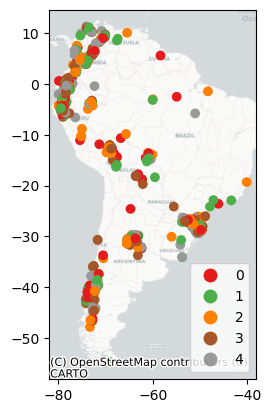

In [13]:
# plot folds on a map
# use a categorical colourmap to visualise folds
ax = gdf_folds.plot(column="fold", categorical=True, cmap="Set1", legend=True)

# Add a basemap
cx.add_basemap(
    ax,
    crs="EPSG:4326",
    source=cx.providers.CartoDB.Positron,
)

plt.show()

## Considerations for geospatial data

In geospatial machine learning we are developing models to generate predictions that can be mapped. To evaluate a map, the desired test dataset is a probability sample of locations, drawn independently from the training data, that is representative of the target area. However, in many cases a test dataset with these characteristics does not exist and it is not possible to collect one. 

If the dataset is spatially auto-correlated and clustered, then spatially naive random subsetting of the dataset into training and test sets (either via a train-test splits or k-fold cross validation) will result in test data that is i) not independent of the training data, and ii) not representative of unsampled locations within the target area. This will result in  underestimating the model's error when the model is deployed in locations within the target area not covered in the training data. A condition for the generating train-test sets or k-fold cross validation via spatially naive random splitting is the the training and test sets are independent, this is not the case with spatially autocorrelated and clustered data. 

Various strategies have been proposed to estimate a model's performance across a target area in the presence of spatially auto-correlated and clustered data. These include:
 
* **Spatially buffered validation**: A buffer distance is used to separate training and test splits. This is to reduce the spatial auto-correlation between training and test examples and provide an estimate of model performance in areas not represented in the training dataset.
* **Spatial k-fold cross validation**: Instead of randomly allocating examples to folds, the dataset is spatially clustered and each cluster forms a fold in k-fold crosss-validation. As each fold is spatially separate from the remaining folds, this gives an indication of how well the model performs when deployed in areas not represented in the training dataset.
* **Nearest neighbour distance matching**: A leave-one-out variant of cross-validation where the examples held out for testing are selected to resemble the distance between the training dataset and the prediction area.
* **k-fold nearest neighbour distance matching**: A variant of k-fold cross-validation where the folds held out for testing are selected to resemble the distance between the training dataset and the prediction area.

The first task when evaluating geospatial machine learning model is to assess how spatially autocorrelated and clustered the dataset is. This will give an early indication as to whether estimates of model performance based on this dataset will underestaimte the model's error when applied to the target area. 

We can visualise the distribition of points across the target area by plotting each point on a scatter plot with longitude and latitude mapped to the x- and y-axes and render histograms of point densities along each axis (see <a href="https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html#introduction" target="_blank">Rey et al. (2020)</a> for more information on point pattern analysis). 

A visual inspection of the data illustrates that our data is not evenly distributed across South America but is clustered along the North- and South-Western coastline with other clusters on the South-East coast of Brazil, on the Brazil-Bolivia border and Northern-Central Argentina. Further, if the data was evenly distributed across the target area the histograms on the x- and y-axes would have similar heights; as they do not it is an indication that the data has some clustered patterns. 

This is an early indication this dataset is not representative of conditions across all of South America and evaluating a model trained and tested using this dataset will give an overly optimistic assessment of the model's performance across the target area. 

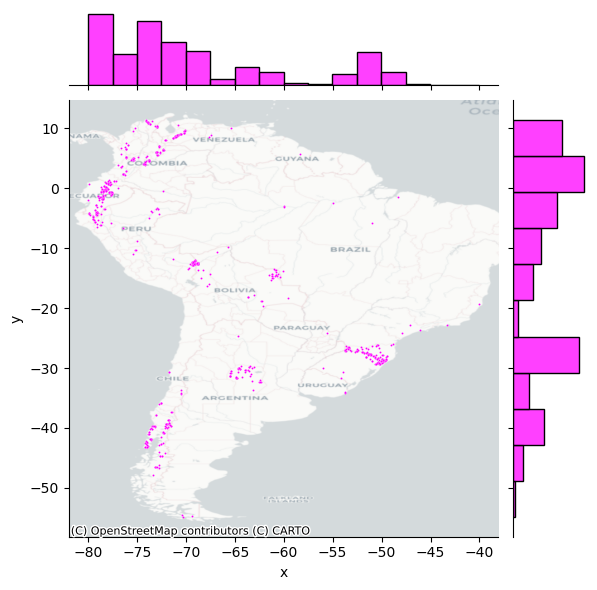

In [14]:
# Evaluate clustering / spatial correlation in the data
gdf_plotting = gdf.copy()

# add x and y columns
gdf_plotting.loc[:, "x"] = gdf_plotting.loc[:, "geometry"].x
gdf_plotting.loc[:, "y"] = gdf_plotting.loc[:, "geometry"].y

# Generate  xy-scatter plot
xy_scatter = sns.jointplot(
    x="x", 
    y="y", 
    data=gdf_plotting, 
    s=2,
    color="magenta",
)

# Add a basemap
cx.add_basemap(
    xy_scatter.ax_joint,
    crs="EPSG:4326",
    source=cx.providers.CartoDB.Positron,
)

### Spatial k-fold cross-validation

We can use spatial k-fold cross-validation to assess how well the model would perform if it was used to generate predictions in locations within the target area where there are no training data. Again, we will write a custom function to perform spatial k-fold cross-validation to make the steps in the process explicit:

1. Create an array with the number of rows (0-axis) corresponding to the number of points in our dataset and two columns (1-axis). The values of the array are x and y values corresponding to longitude and latitude.
2. Use a K Means clustering algorithm to cluster the dataset into $k$ groups with similar longitude and latitude values. These groups become our folds.
3. Loop over fold ids:
    * Hold out the examples with the current fold ids as the test fold.
    * Compute standardisation statistics on the remaining folds (per-variable mean and standard deviation).
    * Standardise the train and test fold input predictors.
    * Train a model using the training folds.
    * Evaluate model using the test folds.
    * Store the metric score in a list.
4. Return the list of metrics scores when all folds have had a turn as the test fold. 

In [28]:
def spatial_cross_validation(gdf, n_folds, model, metric, target_column, cols_to_drop):
    """Function to perform spatial k-fold cross-validation.
    Args:
        gdf (GeoDataFrame): The spatial dataset (GeoDataFrame) containing features and the target variable.
        n_folds (int): The number of spatial folds to use for cross-validation.
        model: The machine learning model to train and evaluate.
        metric: The evaluation metric function to use for computing errors on the test fold.
        target_column (str): The column name for the target variable.
        cols_to_drop (list): Columns to drop that should not be included as predictors. 

    Returns:
        list, GeoDataFrame: A list containing the error metrics computed on each test fold during cross-validation 
        and GeoDataFrame with spatial folds for plotting. 
    """
    gdf_tmp = gdf.copy()

    # split the data into n_folds spatially
    # assign a fold id column to each row

    # add x and y columns
    gdf_tmp.loc[:, "x"] = gdf_tmp.loc[:, "geometry"].x
    gdf_tmp.loc[:, "y"] = gdf_tmp.loc[:, "geometry"].y

    # create an array of x and y values
    X = gdf_tmp.loc[:, ["x", "y"]].copy()

    # create a KMeans clusterer
    km = KMeans(
        n_clusters=n_folds,
        init="random",
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=123,
    )
    spatial_folds = km.fit_predict(X)
    gdf_tmp.loc[:, "fold"] = spatial_folds

    # keep a copy of GeoDataFrame with folds for plotting
    gdf_spatial_folds = gdf_tmp.copy()
    
    # drop columns that should not be included as predictors
    gdf_tmp = gdf_tmp.drop(columns=cols_to_drop)

    # create an empty list to store metrics computed on test fold
    errors = []   
    
    # loop of folds, train a model, and compute error
    for k in range(0, n_folds):
        # subset out test fold
        gdf_test_fold = gdf_tmp.loc[gdf_tmp["fold"] == k, :]
        
        # subset out training folds
        # != is the not equals to operator
        gdf_train_fold = gdf_tmp.loc[gdf_tmp["fold"] != k, :]

        # subset training folds into predictors and targets arrays
        X_train = gdf_train_fold.drop(columns=[target_column, "fold"])
        y_train = gdf_train_fold.loc[:, target_column]

        # subset test fold into predictors and targets arrays
        X_test = gdf_test_fold.drop(columns=[target_column, "fold"])
        y_test = gdf_test_fold.loc[:, target_column]

        # standardise data
        tmp_scaler = StandardScaler().fit(X_train)
        X_train_scaled = tmp_scaler.transform(X_train)
        X_test_scaled = tmp_scaler.transform(X_test)

        # train model 
        m = model.fit(X_train_scaled, y_train)

        # compute error using the test fold 
        y_test_preds = m.predict(X_test_scaled)

        # append errors to list
        errors.append(metric(y_test, y_test_preds))

    # return list error metrics for test folds
    return errors, gdf_spatial_folds

In [16]:
# drop these columns when running spatial cv as they should not be included as predictors
cols_to_drop = ["PlotObservationID", "GIVD_ID", "Country", "Biome", "geometry", "x", "y"]

# set up a model
model = MLPRegressor(hidden_layer_sizes=(50,), random_state=4, solver="sgd", max_iter=500)

# run k-fold cross-validation with 5 folds
spatial_cv_errors, gdf_spatial_folds = spatial_cross_validation(gdf, 5, model, mean_squared_error, "Species_richness", cols_to_drop)

# print spatial cv_errors
for i, e in enumerate(spatial_cv_errors):
    print(f"The MSE for fold {i} is {round(e, 2)}")
    print(f"The RMSE for fold {i} is {round(math.sqrt(e), 2)}")
    print("")

The MSE for fold 0 is 2690.43
The RMSE for fold 0 is 51.87

The MSE for fold 1 is 4013.0
The RMSE for fold 1 is 63.35

The MSE for fold 2 is 3259.69
The RMSE for fold 2 is 57.09

The MSE for fold 3 is 3857.93
The RMSE for fold 3 is 62.11

The MSE for fold 4 is 1331.4
The RMSE for fold 4 is 36.49



Let's quickly visualise the spatial folds.

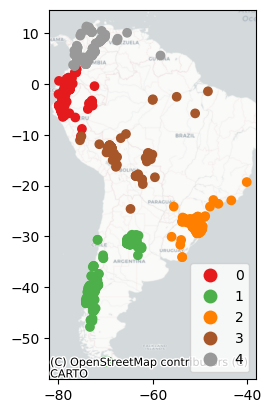

In [17]:
# plot spatial folds on a map
# use a categorical colourmap to visualise folds
ax = gdf_spatial_folds.plot(column="fold", categorical=True, cmap="Set1", legend=True)

# Add a basemap
cx.add_basemap(
    ax,
    crs="EPSG:4326",
    source=cx.providers.CartoDB.Positron,
)

plt.show()

### Summary

For quick viewing, let's print out the error for the random test split, random k-fold cross-validation, and spatial k-fold cross-validation. Let's also plot a histogram of the target variable to get some perspective on the magnitude of the errors relative to the distribution of target specieis richness values in the dataset. 

We can see that the RMSE for the test split and for hold-out folds in random k-fold cross-validation is between 20 and 30. This error is roughly equivalent to a half to two-thirds of a standard deviation of the sepcies richness values in the dataset. However, we can see the spatial k-fold cross-validation error is between 50 and 63 for four out of the five folds. This is more than one standard deviation of the species richness values. Thus, when we account for the spatial clustering structure of the dataset and assess how well the model performs in areas with no training data the error increases. If we relied solely on random test splits or random k-fold cross-validation to judge the performance of our model, we would be overly optimistic about how well it would perform in new locations. 

Random test split error
The RMSE on the test split is: 28.18

Random k-fold cross-validation
The RMSE for fold 0 is 22.16

The RMSE for fold 1 is 28.46

The RMSE for fold 2 is 30.13

The RMSE for fold 3 is 24.27

The RMSE for fold 4 is 29.11


Spatial k-fold cross-validation
The RMSE for fold 0 is 51.87

The RMSE for fold 1 is 63.35

The RMSE for fold 2 is 57.09

The RMSE for fold 3 is 62.11

The RMSE for fold 4 is 36.49

Summary statistics for species richness variable
count    703.000000
mean      39.691323
std       44.919333
min        1.000000
25%       14.000000
50%       23.000000
75%       45.500000
max      256.000000
Name: Species_richness, dtype: float64

Histogram of species richness values


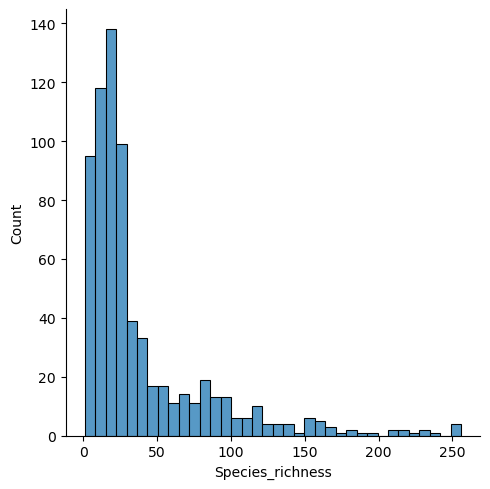

In [18]:
print("Random test split error")
print(f"The RMSE on the test split is: {round(math.sqrt(test_split_mse), 2)}")
print("")

print("Random k-fold cross-validation")
for i, e in enumerate(random_cv_errors):
    print(f"The RMSE for fold {i} is {round(math.sqrt(e), 2)}")
    print("")
print("")

print("Spatial k-fold cross-validation")
for i, e in enumerate(spatial_cv_errors):
    print(f"The RMSE for fold {i} is {round(math.sqrt(e), 2)}")
    print("")

# summary stats and histogram of species richness values in the dataset
print("Summary statistics for species richness variable")
print(gdf["Species_richness"].describe())
print("")
print("Histogram of species richness values")
sns.displot(data=gdf, x="Species_richness")

## Self guided activity! Spatial cross-validation assessment of land cover classification

Using the Fiji land cover classification dataset, can you assess a classification model's accuracy using spatial cross-validation?

#### Activity!

<details>
    <summary><strong>Can you read the Fiji land cover classification data stored in the GeoJSON file <code>fiji_ba_lulc_s2.geojson</code> into a <code>GeoDataFrame</code>?</summary>
    
```
gdf_lc = gpd.read_file(os.path.join(DATA_PATH, "fiji_ba_lulc_s2.geojson"))
gdf_lc.explore(column="class", categorical=True, cmap="Set1")
```
</details>

In [ ]:
## ADD CODE HERE

#### Activity!

<details>
    <summary><strong>Can you explore the level of spatial clustering of the Fiji land cover classification dataset?</summary>
    
```
# Evaluate clustering / spatial correlation in the data
gdf_lc_plotting = gdf_lc.copy()

# add x and y columns
gdf_lc_plotting.loc[:, "x"] = gdf_lc_plotting.loc[:, "geometry"].x
gdf_lc_plotting.loc[:, "y"] = gdf_lc_plotting.loc[:, "geometry"].y

# Generate  xy-scatter plot
xy_scatter = sns.jointplot(
    x="x", 
    y="y", 
    data=gdf_lc_plotting, 
    s=2,
    color="magenta",
)

# Add a basemap
cx.add_basemap(
    xy_scatter.ax_joint,
    crs="EPSG:4326",
    source=cx.providers.CartoDB.Positron,
)
```

You should see there is a far more even distribution of points across the Ba region; this is visible on the map and the adjoining histograms.
</details>

In [ ]:
## ADD CODE HERE

#### Activity!

<details>
    <summary><strong>Can you adapt the random and spatial cross-validation examples above to assess the classifier's performance with the Fiji land cover classification dataset? Use only one hidden layer with 10 units for the model. You can find the documentation for the <code>MLPClassifier</code> <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html", target="_blank">here</a>.</strong></summary>
    
```
cols_to_drop = ["year", "geometry"]

# set the metric to accuracy_score as this is a classification task
# set the target variable to "class"
model = MLPClassifier(hidden_layer_sizes=(10,), random_state=4, solver="sgd", max_iter=500)
random_lc_cv_errors, gdf_folds = random_cross_validation(gdf_lc, 5, model, accuracy_score, "class", cols_to_drop)

model = MLPClassifier(hidden_layer_sizes=(10,), random_state=4, solver="sgd", max_iter=500)
spatial_lc_cv_errors, gdf_spatial_folds = spatial_cross_validation(gdf_lc, 5, model, accuracy_score, "class", cols_to_drop)

print("Random k-fold cross-validation:")
for i, e in enumerate(random_lc_cv_errors):
    print(f"The accuracy for fold {i} is {round(e, 2)}")
    print(f"")

print("Spatial k-fold cross-validation:")
for i, e in enumerate(spatial_lc_cv_errors):
    print(f"The accuracy for fold {i} is {round(e, 2)}")
    print(f"")
```
</details>

In [ ]:
## ADD CODE HERE

## Per-class performance metrics

Thus far we have generated a single performance metric for our model. However, for multi-class classification tasks, like the land cover mapping example, it is important to assess how well the model performs for individual classes. 

#### Activity!

<details>
    <summary><strong>Why is it important to consider class-level performance metrics when assessing model perofrmance?</summary>
    
If our dataset is imbalanced (e.g. we have a lot of examples of one class and only a few from another), the model can get a high accuracy score just by doing well at predicting the majority class (in the most extreme case the model could learn to only generate predictions for the majority class value). If our application is dependent on a particular class then it is important that we're able to judge the model's performance for that class (e.g. forest related applications require good performance of the tree class in land cover classifications).

</details>

### Error matrix

A visual way of assessing a model's per-class performance is a confusion matrix. On a per-class level this lets us visualise true positives, true negatives, false positives and false negatives. The top-left to bottom-right diagonal of the confusion matrix captures the true positive predictions. Ideally, we want to see all of the model's fall on this diagonal and zero values in the off-diagonals. 

The documentation for `scikit-learn`'s confusion matrix tools is <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions" target="_blank">here</a>.

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


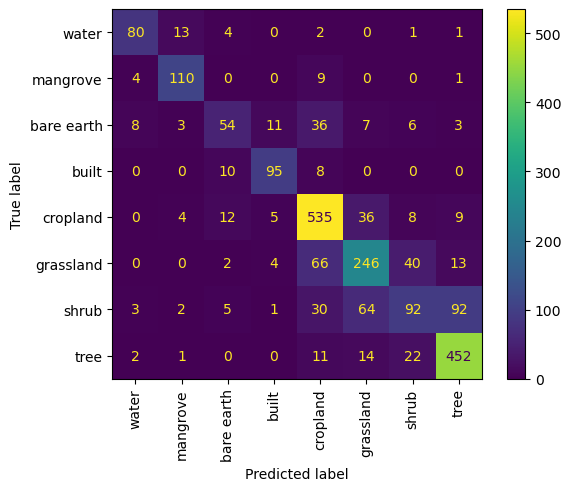

In [26]:
## Confusion matrix

# drop columns not needed for model development
gdf_tmp = gdf_lc.drop(columns=["year", "geometry"]).copy()
X = gdf_tmp.drop(columns=["class"])
y = gdf_tmp.loc[:, "class"]

# create train-test splits and standardise the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
lc_scaler = StandardScaler().fit(X_train)
X_train_scaled = lc_scaler.transform(X_train)
X_test_scaled = lc_scaler.transform(X_test)

# train a classifier
cls = MLPClassifier(hidden_layer_sizes=(10,), random_state=4, solver="sgd", max_iter=500).fit(X_train_scaled, y_train)

# generate test set predictions
y_test_preds = cls.predict(X_test_scaled)

# generate confusion matrix
labels = ["water", "mangrove", "bare earth", "built", "cropland", "grassland", "shrub", "tree"]
ConfusionMatrixDisplay.from_predictions(y_test, y_test_preds, display_labels=labels, xticks_rotation="vertical")

We can see that, in general, the predicted class labels in the test set match the true labels. There is some confusion between cropland, grassland, and shrubs and also between shrubs and trees. There is also some cropland confusion with bare earth. 

### Per-class performance metrics

We can also compute metrics that report on the model's performance for individual classes. 

The *precision metric* for a class is an indication of the model's ability to minimise false positives (i.e. how well the model does at avoiding assigning a class label to an example when it is not that class). In the remote sensing world, this metric is often called the *user's accuracy*. 

The *recall metric* for a class is an indication of the model's ability minimise false negatives (i.e. how well does the model do at assigning a class label to an example when it is that class). In the remote sensing world, this metric is often called *producer's accuracy*.  

You can find a useful description of each of these metrics on <a href="https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall" target="_blank">Google's Machine Learning Course</a>.

There is a helpful <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html" target="_blank"><code>classification report</code></a> tool in `scikit-learn` that we can use to generate per-class performance metrics. 

In [27]:
print(classification_report(y_test, y_test_preds, target_names=labels))

              precision    recall  f1-score   support

       water       0.82      0.79      0.81       101
    mangrove       0.83      0.89      0.86       124
  bare earth       0.62      0.42      0.50       128
       built       0.82      0.84      0.83       113
    cropland       0.77      0.88      0.82       609
   grassland       0.67      0.66      0.67       371
       shrub       0.54      0.32      0.40       289
        tree       0.79      0.90      0.84       502

    accuracy                           0.74      2237
   macro avg       0.73      0.71      0.72      2237
weighted avg       0.73      0.74      0.73      2237



#### Activity!

<details>
    <summary><strong>Look at the precision and recall scores in the classification report. Can you summarise how accurate the classifier is for individual classes?</summary>
    
The model has relatively high recall and precision scores for water, mangrove, built, cropland, and tree classes. For these classes, and this test set, the model is relatively robust to false positives and false negatives. Shrubs and bare earth have low recall scores, this indicates the model fails to classify examples in the test set as these classes when it should do. 

</details>

#### Activity!


<details>
    <summary><strong>Look up the F1-Score in the <code>scikit-learn</code> docs. Why is it a useful performance metric?</summary>
    
This ones on you. Go for it. 

</details>